## **Metis Project**

**Notebook by [Peter B. Goldey](https://www.linkedin.com/in/petergoldey)**

**Table of Contents**

1. [Introduction](#Introduction)
2. [The Problem](#The-problem)
3. [Required Libraries](#Libraries)
4. [Data License Considerations](#Data-license)
5. [Receive | Load the Data](#Data-load)
6. [Data Exploration and Prep](#Data-prep)
    * [feature engineering](#Features)
    * [profiling](#Profiling)
    * [geographic proximity](#Nearest)

**Workbook 2**
7. [Understand Feature Interactions](#Interactions)
8. [Develop | Run Models](#Models)
9. [Evaluate Models](#Evaluation)

Get Macro-Economic Data (Unemployment Rate) from U.S. Bureau of Labor Statistics
Explore the features of the data and do feature engineering to make the data usable for final modeling
Understand the correlationship
Build different models and compare the performance


<a id='Introduction'></a>
**1. Introduction**

**The value proposition for energy efficiency is straight forward**  

"Energy costs are rising and are not likely to drop. While new technologies and renewable energy sources are gaining in popularity, energy efficiency remains the easiest — and single most cost-effective — way to cut energy use. The most energy-efficient buildings in America —  those that have earned EPA’s ENERGY STAR — use 35 percent less energy than typical buildings, all without trade-offs in performance or comfort." -- [wws.energystar.gov](http://www.energystar.gov) 

"The building sector is the single largest user of energy and emitter of greenhouse gasses in the U.S. Today’s buildings consume 40% of U.S. energy, release 30% of U.S. greenhouse gas emissions and 38% of carbon dioxide emissions, and use nearly 13% of all potable water in the U.S.

Given that the U.S. is currently the largest global user of energy, it becomes even more important for the design and construction industry to take a leadership role in making buildings more efficient in their use of energy and water." -- [US Departer of Energy 2013 SmartMarket Reprot](http://energy.gov/sites/prod/files/2013/12/f5/business_case_for_energy_efficiency_retrofit_renovation_smr_2011.pdf)

**The home-buyer's dilema**

Many Americans make home purchase decisions without understanding a give property's energy and utility costs.  Further, there is no current single standard that will help buyer's translate costs to energy efficiency and vice-versa. However, the desire for energy efficieny is there, toping the list of most desired home features [National Association of Home Builder's 2013 Report: "What Do Home Buyers Really Want"](http://eyeonhousing.org/2013/02/what-do-home-buyers-really-want/)

<img src="https://eyeonhousing.files.wordpress.com/2013/02/figure1.jpg" />

**The starting point**

88% of home buyers begin their search online [2015 National Association of Realtors® Real Estate in a Digital Age](https://store.realtor.org/product/report/2015-nar-real-estate-digital-age-report-download).  Yet, no major search portal or brokerage site includes energy efficiency ratings or estimated costs in their search filters.  This is largely due to a lack of ratings standards, utility costs and billing rates, and the environment and usage factors that can so dramatically impact actual costs for the home owner.

Even so:  **Wouldn't it be great if we could scientifically estimate the efficiency of properties based on public records data?**

There are also numerous government and business program opportunities that could benefit from ability to segment properties on energy efficiency scores.  A few include the marketing and educational efforts surrounding:
* energy audit services 
* solar panel installation 
* applican replacement 
* HVAC 
* energy type conversions 
* energy usage incentives 
* window and door replacement 

<a id='The-problem'></a>
**2. The Problem **

Can we use a relavant sample of public records property data to estimate a meaningful and comparative energy efficiency score?
* what data will we use as input?
* what difficulties with the raw data will we need to address?
* what predictive models will we employ and refine?
* is there a relevant scoring dataset such that we can run a supervised learning model?


<a id='Libraries'></a>
**3. Libraries**

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

To make sure you have all of the packages you need, install them with `conda`:

    conda install numpy pandas scikit-learn matplotlib seaborn


In [9]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

np.set_printoptions(precision=4,suppress=True)

<a id='Data-license'></a>
** 4. Data License Considerations **

Set 1: Public Records

Much of the nation's public records are now available online through county clerk and assessor websites where end users can perform searches to pull back specific properties and small subsets.  Gathering the bulk of records for a large area can be difficult through these systems.  Happily, some municipalities are now making bulk datasets available to download.  One such jurisdiction is King County, WA which we have selected for this project.

* A full description of the files available is [provided](http://info.kingcounty.gov/assessor/DataDownload/default.aspx)

* The property data for Boulder is found in 24 .csv files available through this [page](http://info.kingcounty.gov/assessor/DataDownload/default.aspx).  NOTE: we will only use a handful of these files.

Set 2: Energy score and consumption

This dataset is provided courtesy of Enerscore, LLC and privately head startup from Boston that generates estimated energy consumption scores.  We will use this dataset as our reference for supervised learning.  

** Special Data Requirement:  anonymity **

In order to product the record level anonimity of the Enerscore values, I have pre-processed the raw files from both sources to exclude the unique parcel idenfication attributes and instead use an arbitrary unqiue key value.  The only key provided on the Enerscore files, belongs to Onboard Informatics.  The work to anonymize the data was performed in a private notebook as follows:

Step 1: generate lookup file from Onboard database containing these columns:
    * Assessor's parcel ID (Major, Minor)
    * Onboard unique key
    * Unique arbitrary ID (UAID)
We will also include additional columns in this file which may be userful in filtering, clustering or other steps in our process.  These included:
    * Latitude
    * Longitude
    * CensusID
    * Geo_Level (precision of coordinates)
    * Property Type
    
Step 2: merge the lookup file with the Assessor's "buildings" on Assessor's parcel ID ("Major","Minor") and create new output including only the UAID + the non-ID Assessor's columns and additional filtering columns.

Step 3: merge the lookup file with Enerscore's file on Onboard unique key and create new output including only the UAID + the non-ID Enerscore columns.
    
If any of the other county files are required, a similar process will be used.



<a id='Data-load'></a>
** Receive | Load the Data **

In [14]:
# set a raw path so that files can be referenced by name alone
raw_path = os.getcwd()
#'../data/'
# these two files were prepped already to strip identifiable information
buildings = pd.read_csv(raw_path+'/buildings.csv', index_col=0)
enerscore = pd.read_csv(raw_path+'/enerscore.csv', index_col=0)
# this lookup provides categorical translations for values represented by integer lookups in the data
res_lookup =  pd.read_csv(raw_path+'/EXTR_LookUp.csv')
# this file contains degree heating and cooling days.  we believe that variance in this column should
#  impact energy costs (but may be surprised by the results!)
degday = pd.read_csv(raw_path+'/degdayBG_53033.csv')

*** 1. basic data inspection ***
* head
* info
* describe
* value counts (for categoricals)
* correlation matrix (for numerical)

In [15]:
res_lookup.head()
# typical lookup table

,LUType,LUItem,LUDescription
0,1,1,LAND ONLY ...
1,1,10,Land with new building ...
2,1,11,"Household, single family units ..."
3,1,12,"Multiple family residence (Residential, 2-4 un..."
4,1,13,"Multiple family residence (Residential, 5+ uni..."


In [16]:
buildings.head(5)
# shows well formatted data but with null values and many 0 filled values

,BldgNbr,NbrLivingUnits,DirectionPrefix,StreetName,StreetType,DirectionSuffix,ZipCode,Stories,BldgGrade,BldgGradeVar,...,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,PROPERTY_INDICATOR,LATITUDE,LONGITUDE,GEO_LEVEL,GEO_CENSUSID
NEW_KEY,,,,,,,,,,,,,,,,,,,,,
260004,1,1,SW,99TH,ST,,98126,1.0,7,0,...,0,0,0,3,0,10,47.514556,-122.376912,Street,530330120001005
430957,1,1,SW,100TH,ST,,98146,1.0,7,0,...,0,0,0,4,0,10,47.513875,-122.376673,Street,530330120001005
447329,1,1,SW,100TH,ST,,98146,1.0,6,0,...,0,0,0,3,0,10,47.513874,-122.381032,Street,530330120003013
430367,1,1,,MILITARY,RD,S,98168,1.0,7,0,...,0,0,0,3,0,10,47.473424,-122.290609,Street,530330273003019
404781,1,1,S,144TH,ST,,98168,1.5,6,0,...,0,0,0,3,0,10,47.473933,-122.273153,Street,530330282001003


In [17]:
buildings.info()
# show good non-null fill rates for most columns (though we no we have a value = 0 issue)
# ZipCode - an obvious geographical grouping attribute - has a significant volumn of nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493557 entries, 260004 to 87526
Data columns (total 50 columns):
BldgNbr               493557 non-null int64
NbrLivingUnits        493557 non-null int64
DirectionPrefix       493424 non-null object
StreetName            493557 non-null object
StreetType            493557 non-null object
DirectionSuffix       493424 non-null object
ZipCode               465166 non-null object
Stories               493557 non-null float64
BldgGrade             493557 non-null int64
BldgGradeVar          493557 non-null int64
SqFt1stFloor          493557 non-null int64
SqFtHalfFloor         493557 non-null int64
SqFt2ndFloor          493557 non-null int64
SqFtUpperFloor        493557 non-null int64
SqFtUnfinFull         493557 non-null int64
SqFtUnfinHalf         493557 non-null int64
SqFtTotLiving         493557 non-null int64
SqFtTotBasement       493557 non-null int64
SqFtFinBasement       493557 non-null int64
FinBasementGrade      493557 non-null int6

In [18]:
buildings.describe()
# based on comparison of 75% and max values, we can see some high end variance in the data
# this is supported by the narrow std ranges combined with large variance between mean and max values
# columns do not appear to contain negative values
# columns are often left bounded by 0 or 1 
#     (remember 0's are suspicious as they appear to be a fill value)

,BldgNbr,NbrLivingUnits,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,...,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,PROPERTY_INDICATOR,LATITUDE,LONGITUDE,GEO_CENSUSID
count,493557.000000,493557.000000,493557.000000,493557.000000,493557.000000,493557.000000,493557.000000,493557.000000,493557.000000,493557.000000,...,493557.000000,493557.000000,493557.000000,493557.000000,493557.000000,4.935570e+05,493557.000000,493557.000000,493557.000000,4.935570e+05
mean,1.013380,1.022735,1.432974,7.553043,0.012744,1297.198711,54.019254,411.407258,9.215706,1.107787,...,90.208245,0.174493,0.328473,0.012550,3.356615,1.184800e+03,10.256501,47.552979,-122.224178,5.303302e+14
std,0.233074,0.175027,0.508996,1.187600,1.105857,491.770834,181.363601,610.372206,82.547325,29.574356,...,414.333558,3.687497,4.592502,0.758682,0.595614,6.703159e+03,2.431664,0.142179,0.134686,2.323676e+09
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,47.118408,-122.526876,5.303300e+14
25%,1.000000,1.000000,1.000000,7.000000,0.000000,990.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000e+00,10.000000,47.451942,-122.328667,5.303301e+14
50%,1.000000,1.000000,1.000000,7.000000,0.000000,1230.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000e+00,10.000000,47.566181,-122.253798,5.303302e+14
75%,1.000000,1.000000,2.000000,8.000000,0.000000,1510.000000,0.000000,870.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000e+00,10.000000,47.675642,-122.144719,5.303303e+14
max,31.000000,20.000000,5.000000,20.000000,99.000000,22860.000000,8800.000000,14834.000000,14834.000000,4960.000000,...,2016.000000,100.000000,99.000000,100.000000,5.000000,2.500000e+06,90.000000,47.777857,-121.156958,5.306105e+14


In [19]:
degday.head()
# this file contain block group id (GEO_CODE).  This is a subset of the CENSUSID in the buildings file.
# we will execute a one to many join to pull DEGDAYHEAT and DEGDAYCOOL onto the buildings file.

,GEO_CODE,DEGDAYHEAT,DEGDAYCOOL
0,530330323132,5423,802
1,530330323133,5420,802
2,530330323134,5421,802
3,530330323151,5133,685
4,530330323152,5357,795


In [20]:
degday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 3 columns):
GEO_CODE      1420 non-null int64
DEGDAYHEAT    1420 non-null int64
DEGDAYCOOL    1420 non-null int64
dtypes: int64(3)
memory usage: 33.4 KB


In [21]:
degday.describe()

,GEO_CODE,DEGDAYHEAT,DEGDAYCOOL
count,1.420000e+03,1420.000000,1420.000000
mean,5.303302e+11,5361.219718,356.713380
std,1.072652e+05,485.884900,242.438249
min,5.303300e+11,4611.000000,9.000000
25%,5.303301e+11,4918.000000,140.000000
50%,5.303302e+11,5252.000000,323.500000
75%,5.303303e+11,5868.000000,559.000000
max,5.303303e+11,6600.000000,834.000000


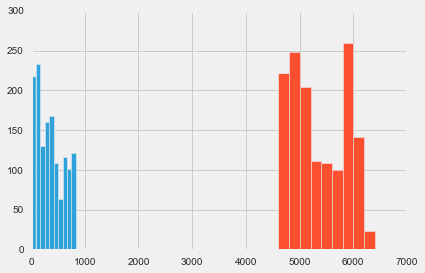

In [22]:
degday.DEGDAYCOOL.hist()
degday.DEGDAYHEAT.hist()
# we can see that there are far more heating degree days than cooling degree days
#   given that we are in the Northwest and on the coast (mostly) this makes sense.

In [23]:
enerscore.head()
# data fill appears good
# categorical and numeric values are obvious
# scale on numerics is not obvious

,EST_HERS_SCORE,HOTWATER,HEATING,BASELOAD,COOLING,HEATING_FUEL_TYPE,DHW_FUEL_TYPE,COOLING_FUEL_TYPE,BASELOAD_FUEL_TYPE,TOTAL_COST
NEW_KEY,,,,,,,,,,
701562,C-,197.055761,215.113231,5576.0,36.272478,gas,gas,electric,electric,950.256070
701488,C-,239.967873,282.263814,7108.0,43.885794,gas,gas,electric,electric,1207.646344
701566,C-,197.055761,215.113231,5576.0,36.272478,gas,gas,electric,electric,950.256070
701565,C-,154.143650,220.935816,4806.0,32.682039,gas,gas,electric,electric,840.870848
701561,C-,197.055761,215.113231,5576.0,36.272478,gas,gas,electric,electric,950.256070


In [24]:
# an inspection of the "type" fields shows them to contain a single unique value.  We will discard it.
print "heating fuel type", enerscore.HEATING_FUEL_TYPE.unique()
print "dhw_fuel_type", enerscore.DHW_FUEL_TYPE.unique()
print "cooling fuel type", enerscore.COOLING_FUEL_TYPE.unique()
print "baseload fuel type", enerscore.BASELOAD_FUEL_TYPE.unique()

heating fuel type ['gas']
dhw_fuel_type ['gas']
cooling fuel type ['electric']
baseload fuel type ['electric']


In [25]:
enerscore.info()
# the data does not contain null values
# inspection of the head (above) and describe (below) do not indicate a 0 fill issues

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628020 entries, 701562 to 702998
Data columns (total 10 columns):
EST_HERS_SCORE        628020 non-null object
HOTWATER              628020 non-null float64
HEATING               628020 non-null float64
BASELOAD              628020 non-null float64
COOLING               628020 non-null float64
HEATING_FUEL_TYPE     628020 non-null object
DHW_FUEL_TYPE         628020 non-null object
COOLING_FUEL_TYPE     628020 non-null object
BASELOAD_FUEL_TYPE    628020 non-null object
TOTAL_COST            628020 non-null float64
dtypes: float64(5), object(5)
memory usage: 52.7+ MB


In [26]:
enerscore.describe()
# the negative HEATING min jumps out:  what does this measure?  are negatives errors?
#  according to the source they may indicate where solar panels are installed and sell energy back to the utility.
#  we will exlude negative values for this analysis
# similar to the buildings data, there is variance or skew at the top end of the column ranges
# while std is larger than for buildings, it is still relatively small compared to max values

,HOTWATER,HEATING,BASELOAD,COOLING,TOTAL_COST
count,628020.000000,628020.000000,628020.000000,628020.000000,628020.000000
mean,194.311182,593.490377,5438.978889,72.702397,1352.631174
std,56.577785,378.252701,2329.904420,38.190338,602.435634
min,68.319426,-2335.352349,1258.000000,2.725267,168.795444
25%,154.143650,392.755389,4656.000000,49.283937,1091.354162
50%,197.055761,539.010859,5552.000000,68.359046,1339.336574
75%,239.967873,730.635020,6430.000000,92.662762,1611.710643
max,4102.057924,58851.595207,655908.400000,4068.741504,115323.011244


<a id='Data-prep'></a>
** Data Exploration and Prep **

1. inspect ** enscore ** data set object datatype values
    * are they categoricals?
    * will then benefit the analysis?
    * NOTE: these are the values which Enerscore uses to estimate total cost.  Our goal is to estimate total cost based on other features in the dataset.


In [27]:
print "EST_HERS_SCORE\n",enerscore.EST_HERS_SCORE.value_counts()
print "HEATING_FUEL_TYPE\n",enerscore.HEATING_FUEL_TYPE.value_counts()
print "DHW_FUEL_TYPE\n",enerscore.DHW_FUEL_TYPE.value_counts()
print "COOLING_FUEL_TYPE\n",enerscore.COOLING_FUEL_TYPE.value_counts()
print "BASELOAD_FUEL_TYPE\n",enerscore.BASELOAD_FUEL_TYPE.value_counts()

EST_HERS_SCORE
D-    240645
E     130058
E-     84867
F      81997
D+     72493
C-     11810
D       5466
E+       433
C        189
F+        62
Name: EST_HERS_SCORE, dtype: int64
HEATING_FUEL_TYPE
gas    628020
Name: HEATING_FUEL_TYPE, dtype: int64
DHW_FUEL_TYPE
gas    628020
Name: DHW_FUEL_TYPE, dtype: int64
COOLING_FUEL_TYPE
electric    628020
Name: COOLING_FUEL_TYPE, dtype: int64
BASELOAD_FUEL_TYPE
electric    628020
Name: BASELOAD_FUEL_TYPE, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EB19550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000FD17780>]], dtype=object)

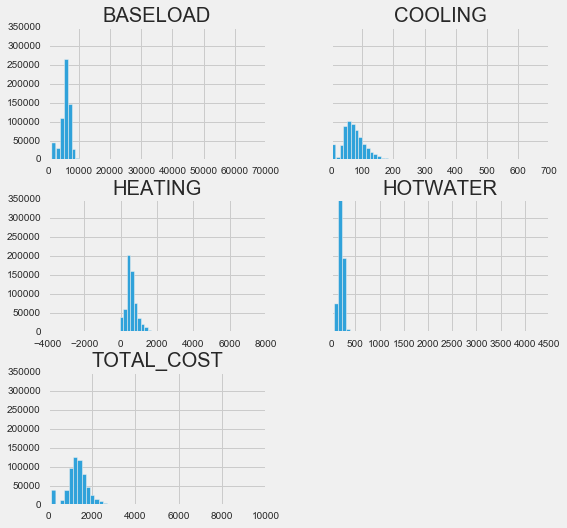

In [28]:
# reviewing the histograms for the energy usage columns, we see that the units are very different
#  it turns out that these are units of the appropriate energy type, not a $ or uniformly scaled value
# the distributions appear somewhat normal but with some skew to the right.
enerscore[(enerscore.TOTAL_COST<10000)].hist(figsize=[8,8],bins=50
                                             , sharey=True)

** Findings: **
1. there are no NaN / null values
2. only the EST_HERS_SCORE has differentiated values.  
3. the other object columns contain only a single categorical value
    * it may be that in other counties, these columns will contain multiple labels which may be useful in analysis.  
    * we will not use them for this example county.

#2. inspect ** buildings ** data set object datatype values
    * are they categoricals?
    * will then benefit the analysis?

In [29]:
print "DirectionPrefix\n",buildings.DirectionPrefix.value_counts()
print "StreetName\n",buildings.StreetName.value_counts()
print "StreetType\n",buildings.StreetType.value_counts()
print "DirectionSuffix\n",buildings.DirectionSuffix.value_counts()
print "ZipCode\n",buildings.ZipCode.value_counts()
print "DaylightBasement\n",buildings.DaylightBasement.value_counts()
print "ViewUtilization\n",buildings.ViewUtilization.value_counts()
print "PROPERTY_INDICATOR\n",buildings.PROPERTY_INDICATOR.value_counts()
print "GEO_LEVEL\n",buildings.GEO_LEVEL.value_counts()

DirectionPrefix
      297046
NE     59409
SE     56175
S      30187
SW     18886
N      11579
NW     11069
E       4998
W       4075
Name: DirectionPrefix, dtype: int64
StreetName
8TH                          4257
2ND                          4209
12TH                         4084
3RD                          4058
4TH                          3970
10TH                         3821
26TH                         3801
25TH                         3663
20TH                         3564
35TH                         3524
24TH                         3460
14TH                         3458
1ST                          3448
42ND                         3376
21ST                         3314
30TH                         3300
23RD                         3279
11TH                         3228
32ND                         3221
37TH                         3217
28TH                         3216
5TH                          3150
22ND                         3087
17TH                         3073
18TH

** Findings **
Generally, the ** buildings ** dataset has more interesting categorical data and several issues including 

* null values 
* lack of standardized values ("N" and "n", etc.).  
* skewed values - in particular PROPERTY_INDICATOR
    * upon research, we only want = 10 for single family residential.  



Original enerscore matrix shape: (5L, 5L)
The correlation matrix for the enerscore dataset:


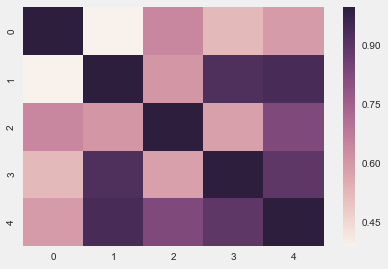

In [30]:
enerscore_corr = enerscore[["HOTWATER","HEATING","BASELOAD","COOLING","TOTAL_COST"]]
enerscore_corr_final = np.corrcoef(enerscore_corr.T)
print "Original enerscore matrix shape:",enerscore_corr_final.shape
sns.heatmap(enerscore_corr_final, xticklabels=True, yticklabels=True)
print "The correlation matrix for the enerscore dataset:"

# surprisingly we see no correlation between HEATING [1] and HOTWATER [0] usage
# TOTAL_COST [4] appears at least somewhat positively correlated with all of the 
#     consumption variable (which logically makes sense)

Original buildings corr matrix shape: (10L, 10L)
The correlation matrix for the buildings dataset:


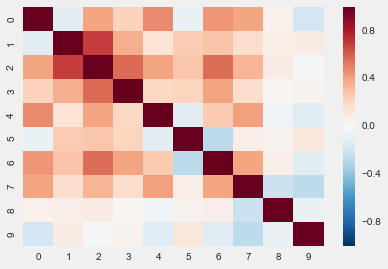

In [31]:
buildings_corr = buildings[["Stories","SqFt1stFloor","SqFtTotLiving","Bedrooms",
                            "BathHalfCount","Bath3qtrCount","BathFullCount",
                            "YrBuilt","YrRenovated","Condition"]]
buildings_corr_final = np.corrcoef(buildings_corr.T)
print "Original buildings corr matrix shape:",buildings_corr_final.shape
sns.heatmap(buildings_corr_final)
print "The correlation matrix for the buildings dataset:"

# there are a number of interesting relationships here - though I believe we need to account for
#    0 fill values before assigning too much importance
# the weak correlations between "YrRenovated" [8] and everything else
# the negative correlation between "YrBuilt" [7] and "Condition" [8]
#    domain expertise suggests we need to combine these year columns with priority on non-0 renovated
# the baths columns [4, 5, 6] : should likely be combined to a single count column
# the relationship between "SqFtTotLiving" [2] and "Bedrooms" [3] is not as positive as one might assume

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001330B470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000104165F8>]], dtype=object)

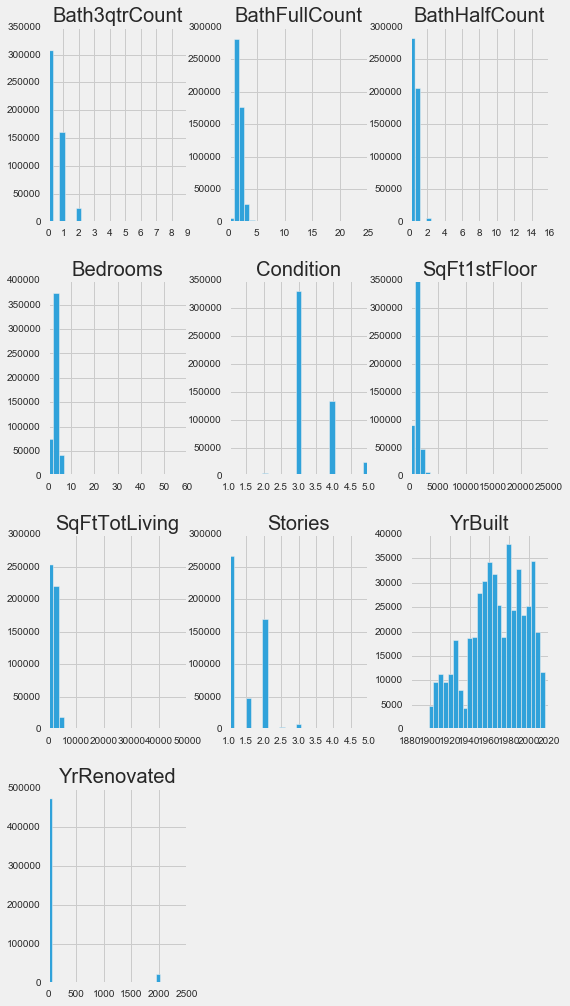

In [32]:
buildings_corr.hist(figsize=[8,16],bins=25)

<a id='Features'></a>
** Feature Engineering **

1. selective merge YrRenovated and YrBuilt --> YrBuiltFinal
2. combine bathroom columns to generate total bathroom count
3. combine degdaycool and degdayheat to get total energy degrees
4. filter for residential only properties
5. create substring of buildings.GEO_CENSUSID for merge to degday table
6. one hot encoding for categoricals.
7. convert total_cost to an int

## Buildings file

In [33]:
#1 merge YrRenovated and YrBuilt --> YrBuiltFinal
#   use conditional logic to use Renvote (if > 0), else use Built
buildings.loc[:,("YrBuiltFinal")] = np.where(buildings.loc[:,('YrRenovated')] == 0
                                              , buildings.loc[:,('YrBuilt')]
                                              , buildings.loc[:,('YrRenovated')])

In [34]:
buildings["Age"] = 1+(2016 - buildings["YrBuiltFinal"])

In [35]:
buildings[["YrRenovated", "YrBuilt", "YrBuiltFinal","Age"]].head(10)

,YrRenovated,YrBuilt,YrBuiltFinal,Age
NEW_KEY,,,,
260004,0,1938,1938,79
430957,0,1956,1956,61
447329,0,1937,1937,80
430367,0,1953,1953,64
404781,0,1904,1904,113
417565,0,1961,1961,56
443499,0,1963,1963,54
443451,0,1942,1942,75
443457,0,1959,1959,58


In [36]:
# create BathCountFinal column
buildings["BathCountFinal"] = buildings["BathHalfCount"]+buildings["Bath3qtrCount"]+buildings["BathFullCount"]

In [37]:
# filter rows to eliminate 0 values in predictor columns
buildingsFinal= buildings[(buildings["Bedrooms"]>0) 
                          & (buildings["BathCountFinal"]>0) 
                          & (buildings["SqFtTotLiving"]>0)
                          & (buildings["YrBuiltFinal"]>0)
                          & (buildings["HeatSystem"]>0)
                          & (buildings["HeatSource"]>0)
                          & (buildings["PROPERTY_INDICATOR"]==10)].copy() 

In [38]:
#buildingsFinal["Condition"].value_counts()
#buildingsFinal["HeatSystem"].value_counts()
buildingsFinal["HeatSource"].value_counts()

2    325953
1     77357
3     77301
5       519
7       517
6       278
4        83
Name: HeatSource, dtype: int64

In [39]:
# note the following:
#   the following are categoricals or ordered values:
#      BldgGrade, Age, Condition, HeatSystem, HeatSource
buildingsPredict = buildingsFinal[["Stories","BldgGrade",
                                   "SqFtTotLiving","Bedrooms",
                                   "BathCountFinal","Age",
                                   "YrBuiltFinal","Condition",
                                   "HeatSystem","HeatSource","GEO_CENSUSID"]]
buildingsPredict.describe()

,Stories,BldgGrade,SqFtTotLiving,Bedrooms,BathCountFinal,Age,YrBuiltFinal,Condition,HeatSystem,HeatSource,GEO_CENSUSID
count,482008.000000,482008.000000,482008.000000,482008.000000,482008.000000,482008.000000,482008.000000,482008.000000,482008.000000,482008.000000,4.820080e+05
mean,1.432554,7.571482,2060.588994,3.339598,2.363170,46.848266,1970.151734,3.360515,4.846490,2.011128,5.303302e+14
std,0.508910,1.179603,937.287050,0.926745,0.984448,27.905734,27.905734,0.594699,0.902685,0.605938,2.333450e+09
min,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,1.000000,1.000000,5.303300e+14
25%,1.000000,7.000000,1410.000000,3.000000,2.000000,24.000000,1952.000000,3.000000,5.000000,2.000000,5.303301e+14
50%,1.000000,7.000000,1900.000000,3.000000,2.000000,44.000000,1973.000000,3.000000,5.000000,2.000000,5.303302e+14
75%,2.000000,8.000000,2512.000000,4.000000,3.000000,65.000000,1993.000000,4.000000,5.000000,2.000000,5.303303e+14
max,5.000000,20.000000,48160.000000,58.000000,24.000000,117.000000,2016.000000,5.000000,8.000000,7.000000,5.306105e+14


## **Categoricals**
There are four categorical columns in our dataset.  Each is described briefly below:

**BldgGrade**

Describes the general construction quality and type of the structure.  The values are ordered so we will let the model work on the feature as a numerical value.  The values in the data are:

1  Cabin                                          
2  Substandard                                    
3  Poor                                           
4  Low                                            
5  Fair                                           
6  Low Average                                    
7  Average                                        
8  Good                                           
9  Better                                         
10 Very Good                                      
11 Excellent                                      
12 Luxury                                         
13 Mansion                                        
20 Exceptional Properties                         


**Condition**

Described the current upkeep and condition of the structure.  The values are ordered so we will let the model work on the feature as a numerical value.  The values in the data are:

1	Poor                                              
2	Fair                                              
3	Average                                           
4	Good                                              
5	Very Good                                         

**HeatSystem**

Describes the type of heating infrastructure.  This is an unordered set of labels, so we will transpose to numerical columns.  The values in the data are:

1	Floor-Wall                                        
2	Gravity                                           
3	Radiant                                           
4	Elec BB                                           
5	Forced Air                                        
6	Hot Water                                         
7	Heat Pump                                         
8	Other 

**HeatSource**

Describes the fuel / power source.  This is an unordered set of labels, so we will transpose to numerical columns.  The values in the data are:

1	Oil                                               
2	Gas                                               
3	Electricity                                       
4	Oil/Solar                                         
5	Gas/Solar                                         
6	Electricity/Solar                                 
7	Other                                             


In [40]:
# convert HeatSource to columns

heatsource_dummies = pd.get_dummies(buildingsPredict.HeatSource, prefix="HeatSource").astype(int)
heatsource_dummies = heatsource_dummies.iloc[:,:-1]
print heatsource_dummies.head()

# convert HeatSystem to columns

heatsystem_dummies = pd.get_dummies(buildingsPredict.HeatSystem, prefix="HeatSystem").astype(int)
heatsystem_dummies = heatsystem_dummies.iloc[:,:-1]
print heatsystem_dummies.head()

# concatentate to predict dataframe
buildingsPredict = pd.concat([buildingsPredict,heatsource_dummies],axis=1) 
buildingsPredict = pd.concat([buildingsPredict,heatsystem_dummies],axis=1) 

# drop original categorical columns
buildingsPredict.drop("HeatSource",inplace=True,axis=1)
buildingsPredict.drop("HeatSystem",inplace=True,axis=1)
# buildingsPredict.info()

         HeatSource_1  HeatSource_2  HeatSource_3  HeatSource_4  HeatSource_5  \
NEW_KEY                                                                         
260004              0             0             1             0             0   
430957              0             1             0             0             0   
447329              0             0             1             0             0   
430367              1             0             0             0             0   
404781              0             1             0             0             0   

         HeatSource_6  
NEW_KEY                
260004              0  
430957              0  
447329              0  
430367              0  
404781              0  
         HeatSystem_1  HeatSystem_2  HeatSystem_3  HeatSystem_4  HeatSystem_5  \
NEW_KEY                                                                         
260004              0             0             1             0             0   
430957              0

In [41]:
# create censusid for matching
#  need to slice off last 3 digits of GEO_CENSUSID
#   1. convert to string
buildingsPredict['GEO_CODE'] = buildingsPredict['GEO_CENSUSID'].astype(str)
#   2. slice first 12 characters
buildingsPredict.GEO_CODE = buildingsPredict.GEO_CODE.map(lambda x: x[:12])
buildingsPredict.head()


,Stories,BldgGrade,SqFtTotLiving,Bedrooms,BathCountFinal,Age,YrBuiltFinal,Condition,GEO_CENSUSID,HeatSource_1,...,HeatSource_5,HeatSource_6,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,GEO_CODE
NEW_KEY,,,,,,,,,,,,,,,,,,,,,
260004,1.0,7,1100,3,1,79,1938,3,530330120001005,0,...,0,0,0,0,1,0,0,0,0,530330120001
430957,1.0,7,990,3,1,61,1956,4,530330120001005,0,...,0,0,0,0,0,0,1,0,0,530330120001
447329,1.0,6,670,2,1,80,1937,3,530330120003013,0,...,0,0,0,0,0,1,0,0,0,530330120003
430367,1.0,7,1460,2,1,64,1953,3,530330273003019,1,...,0,0,0,0,0,0,0,1,0,530330273003
404781,1.5,6,1470,2,1,113,1904,3,530330282001003,0,...,0,0,0,0,0,0,1,0,0,530330282001


## Degree Day file
#### degree days are the difference between 65 and the day's average temperature

* heating degree days (heating)
* cooling degree days (AC)

In [42]:
# create DegreeDays column
degday["DegreeDays"] = degday["DEGDAYCOOL"]+degday["DEGDAYHEAT"]
# change GEO_CODE to string for merge
degday.GEO_CODE = degday.GEO_CODE.astype(str)

In [43]:
# merge to buildingsPredict on shared key but keep the building file index
buildingsPredictDegDay = buildingsPredict.reset_index().merge(degday, on='GEO_CODE').set_index('NEW_KEY')
buildingsPredictDegDay.head()

,Stories,BldgGrade,SqFtTotLiving,Bedrooms,BathCountFinal,Age,YrBuiltFinal,Condition,GEO_CENSUSID,HeatSource_1,...,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,GEO_CODE,DEGDAYHEAT,DEGDAYCOOL,DegreeDays
NEW_KEY,,,,,,,,,,,,,,,,,,,,,
260004,1.0,7,1100,3,1,79,1938,3,530330120001005,0,...,0,1,0,0,0,0,530330120001,5064,103,5167
430957,1.0,7,990,3,1,61,1956,4,530330120001005,0,...,0,0,0,1,0,0,530330120001,5064,103,5167
256946,1.0,6,770,2,1,80,1937,4,530330120001004,1,...,0,0,0,0,0,0,530330120001,5064,103,5167
293798,1.5,6,680,1,1,82,1935,3,530330120001005,0,...,0,0,0,1,0,0,530330120001,5064,103,5167
256967,2.0,8,2500,3,3,10,2007,3,530330120001004,0,...,0,0,0,1,0,0,530330120001,5064,103,5167


## Enerscore file

* convert total cost ($USD) to int

In [44]:
#enerscore.TOTAL_COST = enerscore.TOTAL_COST.astype(int)
enerscore.head()

,EST_HERS_SCORE,HOTWATER,HEATING,BASELOAD,COOLING,HEATING_FUEL_TYPE,DHW_FUEL_TYPE,COOLING_FUEL_TYPE,BASELOAD_FUEL_TYPE,TOTAL_COST
NEW_KEY,,,,,,,,,,
701562,C-,197.055761,215.113231,5576.0,36.272478,gas,gas,electric,electric,950.256070
701488,C-,239.967873,282.263814,7108.0,43.885794,gas,gas,electric,electric,1207.646344
701566,C-,197.055761,215.113231,5576.0,36.272478,gas,gas,electric,electric,950.256070
701565,C-,154.143650,220.935816,4806.0,32.682039,gas,gas,electric,electric,840.870848
701561,C-,197.055761,215.113231,5576.0,36.272478,gas,gas,electric,electric,950.256070


In [45]:
# join in our known labels (the two methods below are logically identical)

#buildingsPredictFinal2 = pd.merge(buildingsPredict, enerscore,left_index=True
#                                 , right_index=True, how='inner')

buildingsPredictFinal = buildingsPredictDegDay.join(enerscore, how='inner')
buildingsPredictFinal.head()

,Stories,BldgGrade,SqFtTotLiving,Bedrooms,BathCountFinal,Age,YrBuiltFinal,Condition,GEO_CENSUSID,HeatSource_1,...,EST_HERS_SCORE,HOTWATER,HEATING,BASELOAD,COOLING,HEATING_FUEL_TYPE,DHW_FUEL_TYPE,COOLING_FUEL_TYPE,BASELOAD_FUEL_TYPE,TOTAL_COST
NEW_KEY,,,,,,,,,,,,,,,,,,,,,
116,3.0,8,1590,3,3,2,2015,3,530330013003009,0,...,C-,197.055761,194.801714,5462.0,34.687670,gas,gas,electric,electric,917.739470
234,2.0,9,2190,4,3,2,2015,3,530330078002031,0,...,C-,239.967873,193.208997,6472.0,37.276278,gas,gas,electric,electric,1053.003333
235,3.0,9,3020,4,4,2,2015,3,530330078002031,0,...,C-,282.879985,274.505740,7620.0,49.122485,gas,gas,electric,electric,1292.122357
236,2.0,9,2810,4,4,2,2015,3,530330063004023,0,...,C-,239.967873,246.927984,6844.0,41.253289,gas,gas,electric,electric,1145.249980
629,2.0,9,3350,4,4,2,2015,3,530330042005001,0,...,C-,239.967873,290.032236,7168.0,44.466211,gas,gas,electric,electric,1221.538365


In [46]:
# output file to use as input to part2 notebook
buildingsPredictFinal.to_csv(raw_path+'buildingsPredictFinal.csv')

<a id="Spatial"></a>
## ** Find Nearest N (geo-spatial) **

For imputing values and also for potential test scenarios, we wish to find homes that are proximally located.  Typically such homes would share utility services and fees and often builder and style.

To establish spatial nearness in a 3d model, there are undoubtedly approaches to take within Python and some of its GIS based addons such as [Folium](https://github.com/python-visualization/folium), [Leaflet](http://leafletjs.com/) and [GeoPy](https://pypi.python.org/pypi/geopy).  However, for this project we will use [Atleryx](http://www.alteryx.com/products/alteryx-designer) which is a spatial toolset specifically designed to answer this and other GIS questions.  Open source products such as QGIS and perform similar functions.

In [48]:
# prepare file for Alteryx import
# filters for SFR only with precise geo coding, limit to required columns
buildings10_loc = buildingsFinal[['LATITUDE','LONGITUDE','GEO_LEVEL']][(buildingsFinal.GEO_LEVEL == 'Street') & (buildingsFinal.PROPERTY_INDICATOR == 10)].copy()
buildings10_loc.to_csv(raw_path+'/buildings10_loc.csv')


** run Alteryx "nearest neighbor" workflow **
* I used 10 nearby properties
* limited to 1km
* output = 10 records for every input and includes rank, distance, etc.
* a small number of records have no "neighbors" - they are isolated mountain homes

In [49]:
# load Alteryx output file.
# note that NEW_KEY is no longer unique so I've let pandas add a new index
buildings10_nearest = pd.read_csv(raw_path+'/buildings10_loc_nearest.csv')

In [50]:
buildings10_nearest.head()

,NEW_KEY,LATITUDE,LONGITUDE,GEO_LEVEL,Universe_NEW_KEY,Universe_LATITUDE,Universe_LONGITUDE,Universe_GEO_LEVEL,FindNearestRank,DistanceKilometers,Direction
0,109380,47.367691,-122.072251,Street,109379,47.367711,-122.072220,Street,1,0.003223,NE
1,109380,47.367691,-122.072251,Street,109378,47.367731,-122.072190,Street,2,0.006391,NE
2,109380,47.367691,-122.072251,Street,109373,47.367909,-122.072490,Street,3,0.030176,NW
3,109380,47.367691,-122.072251,Street,109374,47.367929,-122.072460,Street,4,0.030774,NW
4,109380,47.367691,-122.072251,Street,109375,47.367949,-122.072429,Street,5,0.031648,NW


<a id='Profiling'></a>
** Basic Profiling **


<a id='Interactions'></a>
** Understand Feature Interactions **


<a id='Models'></a>
** Develop | Run Models **


<a id='Evaluation'></a>
** Evaluate Models **